In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve

In [329]:
df_train = pd.read_csv("/DataWorld/Data_Science/datasets/CrossSelling/train.csv/train.csv")
df_test = pd.read_csv("/DataWorld/Data_Science/datasets/CrossSelling/test.csv/test.csv")
submission_df = pd.read_csv("/DataWorld/Data_Science/datasets/CrossSelling/sample_submission_iA3afxn.csv")

## Check the look and feel of the data

In [330]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [331]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [332]:
submission_df.head()

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0


## Combine train and test data for unification/cleaning/wragling/normalizing

In [333]:
df_train['source'] = 'train'
df_test['source'] = 'test'
df = pd.concat([df_train,df_test])
df.reset_index(inplace=True,drop=True)
df.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1.0,train
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0.0,train
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1.0,train


In [334]:
df.tail(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
508143,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74,NaN,test
508144,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265,NaN,test
508145,508146,Male,41,1,29.0,1,1-2 Year,No,27927.0,124.0,231,NaN,test


In [335]:
df['source'].value_counts()

train    381109
test     127037
Name: source, dtype: int64

## Check Shapes of Train and Test data

In [336]:
df_train.shape

(381109, 13)

In [337]:
df_test.shape

(127037, 12)

In [338]:
df.shape

(508146, 13)

## Check for duplicates of data

In [339]:
df_train.duplicated().sum()

0

In [340]:
df_test.duplicated().sum()

0

In [341]:
df.drop(columns=['source','Response']).duplicated().sum()

0

## Understanding of Target variable

## Summary
1. 12% are only the right targetted customers among all. hence percentage is small

In [342]:
df_train['Response'].value_counts(dropna=False)

0    334399
1     46710
Name: Response, dtype: int64

<AxesSubplot:ylabel='Response'>

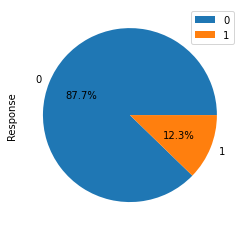

In [343]:
df_train['Response'].value_counts(normalize=True,dropna=False).plot(kind='pie',legend=True,autopct= '%1.1f%%')

## Understanding the data and summary of observations.
1. Data is free of Null values. Good to have.
    ### Column specific understandings: 
        Numerical continuous : Age,Vintage,Annual_Premium,
        Numerical discrete   :
        Categorical ordinal  : Vehicle_Age
        Categorical nominal  : Gender,Driving_License,Previously_Insured,Vehicle_Damage,Policy_Sales_Channel
        
2. <b>id</b> : needs to be dropped during training.
3. <b>Gender</b> : 
       univariate : Data set has approximately same percentage of men and women presence
       bivariate  : Both have same probability to get response
4. <b>Driving_License</b> : 
       univariate : Data set has people who has driving license mostly.
       bivariate  : We have more response from the people who has driving license
5. <b>Previously_Insured</b> : 
       univariate : Data set has approximately same percentage of already having and not having the vehicle insurance
       bivariate  : We have good respones from the People who don't have the vehicle insurance already 
6. <b>Vehicle_Damage</b> : 
       univariate : Data set has approximately same percentage of history of damage and non damage.
       bivariate  : We have more responses from the people with history of damage 
7. <b>Policy_Sales_Channel</b> : 
       univariate : Data set has approximately same percentage of men and women presence
       bivariate  : Both have same probability to get response.
8. <b>Vehicle_Age</b> : 
       univariate : Given data consist of 95% customers whose vehicle age is 0 to 2 years. only 5% are having more than 2 years.
       bivariate  : We have good responses from the customers with vehicle age > 2 years and least reponses from the customers with vehicle age <1
9. <b>Age</b> : 
       univariate : we have customers across the age slabs
       bivariate  : not much difference among age groups
10. <b>Vintage</b> : 
        univariate : We have given the data with max 300 days which is around 10 months of data
        bivariate  : Responses are independent of vingage as it has response ratio even across the vintage. Starting month and last ( 10 months) vintage customers given less response when compare to other categories
11. <b>Annual_Premium</b> :
        univariate : Data set has more medium level pay customers and very less of 'very high' amount of premiums
        bivariate  : not much difference among premiums slabs.

In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508146 entries, 0 to 508145
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    508146 non-null  int64  
 1   Gender                508146 non-null  object 
 2   Age                   508146 non-null  int64  
 3   Driving_License       508146 non-null  int64  
 4   Region_Code           508146 non-null  float64
 5   Previously_Insured    508146 non-null  int64  
 6   Vehicle_Age           508146 non-null  object 
 7   Vehicle_Damage        508146 non-null  object 
 8   Annual_Premium        508146 non-null  float64
 9   Policy_Sales_Channel  508146 non-null  float64
 10  Vintage               508146 non-null  int64  
 11  Response              381109 non-null  float64
 12  source                508146 non-null  object 
dtypes: float64(4), int64(5), object(4)
memory usage: 50.4+ MB


In [345]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,381109.000000
mean,254073.500000,38.808413,0.997936,26.406572,0.458667,30554.453041,111.975838,154.340123,0.122563
std,146689.259281,15.500179,0.045388,13.224921,0.498289,17146.574625,54.246027,83.668793,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,127037.250000,25.000000,1.000000,15.000000,0.000000,24381.000000,26.000000,82.000000,0.000000
50%,254073.500000,36.000000,1.000000,28.000000,0.000000,31661.000000,133.000000,154.000000,0.000000
75%,381109.750000,49.000000,1.000000,35.000000,1.000000,39403.750000,152.000000,227.000000,0.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [346]:
df.describe(include=np.object)

/tmp/ipykernel_96781/3211851552.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df.describe(include=np.object)


,Gender,Vehicle_Age,Vehicle_Damage,source
count,508146,508146,508146,508146
unique,2,3,2,2
top,Male,1-2 Year,Yes,train
freq,274325,267015,256248,381109


In [347]:
# Observation : Good that no null values present
df.isna().sum()

id                           0
Gender                       0
Age                          0
Driving_License              0
Region_Code                  0
Previously_Insured           0
Vehicle_Age                  0
Vehicle_Damage               0
Annual_Premium               0
Policy_Sales_Channel         0
Vintage                      0
Response                127037
source                       0
dtype: int64

#### Univariate analysis of Gender column

In [348]:
df['Gender'].value_counts(dropna=False)

Male      274325
Female    233821
Name: Gender, dtype: int64

<AxesSubplot:ylabel='Gender'>

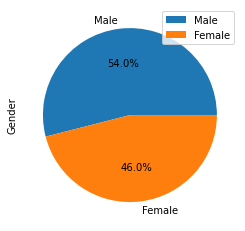

In [349]:
df['Gender'].value_counts(normalize=True,dropna=False).plot(kind='pie',legend=True,autopct= '%1.1f%%')


#### Bivariate analysis of Gendor column

<AxesSubplot:xlabel='Gender'>

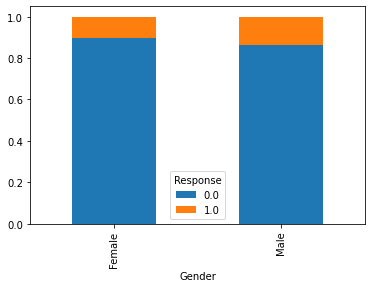

In [350]:
Gender = pd.crosstab(df['Gender'],df['Response'])
Gender.div(Gender.sum(1).astype('float'),axis=0).plot(kind='bar', stacked=True)

#### Univariate analysis of Driving_License column

In [351]:
df['Driving_License'].value_counts(dropna=False)

1    507097
0      1049
Name: Driving_License, dtype: int64

<AxesSubplot:ylabel='Driving_License'>

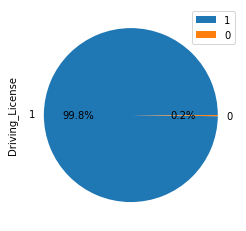

In [352]:
df['Driving_License'].value_counts(normalize=True,dropna=False).plot(kind='pie',legend=True,autopct= '%1.1f%%')


#### Bivariate analysis of Driving_License column

<AxesSubplot:xlabel='Driving_License'>

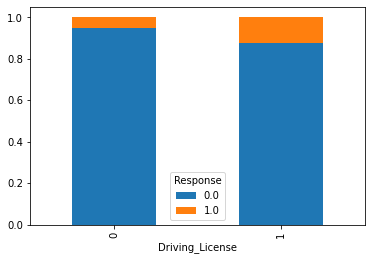

In [353]:
Driving_License = pd.crosstab(df['Driving_License'],df['Response'])
Driving_License.div(Driving_License.sum(1).astype('float'),axis=0).plot(kind='bar', stacked=True)

#### Univariate analysis of Previously_Insured column

#### Univariate analysis of Gender column

In [354]:
df['Previously_Insured'].value_counts(dropna=False)

0    275076
1    233070
Name: Previously_Insured, dtype: int64

<AxesSubplot:ylabel='Previously_Insured'>

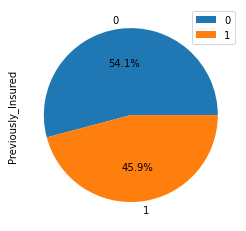

In [355]:
df['Previously_Insured'].value_counts(normalize=True,dropna=False).plot(kind='pie',legend=True,autopct= '%1.1f%%')


#### Bivariate analysis of Previously_Insured column

<AxesSubplot:xlabel='Previously_Insured'>

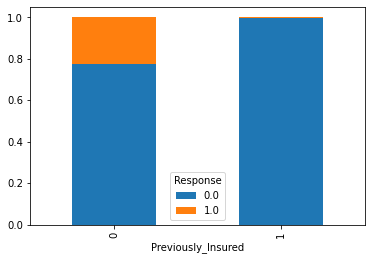

In [356]:
Previously_Insured = pd.crosstab(df['Previously_Insured'],df['Response'])
Previously_Insured.div(Previously_Insured.sum(1).astype('float'),axis=0).plot(kind='bar', stacked=True)

#### Univariate analysis of Driving license column

In [357]:
df['Vehicle_Damage'].value_counts(dropna=False)

Yes    256248
No     251898
Name: Vehicle_Damage, dtype: int64

<AxesSubplot:ylabel='Vehicle_Damage'>

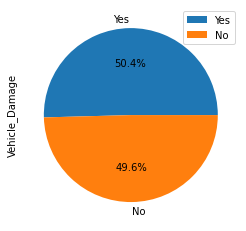

In [358]:
df['Vehicle_Damage'].value_counts(normalize=True,dropna=False).plot(kind='pie',legend=True,autopct= '%1.1f%%')


#### Bivariate analysis of Driving license column

<AxesSubplot:xlabel='Vehicle_Damage'>

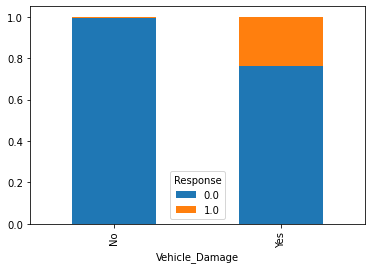

In [359]:
Vehicle_Damage = pd.crosstab(df['Vehicle_Damage'],df['Response'])
Vehicle_Damage.div(Vehicle_Damage.sum(1).astype('float'),axis=0).plot(kind='bar', stacked=True)

#### Univariate analysis of Policy_Sales_Channel column

In [360]:
df['Policy_Sales_Channel'].value_counts(dropna=False).head(30)

152.0    179523
26.0     106594
124.0     98299
160.0     29090
156.0     14313
122.0     13239
157.0      8958
154.0      7988
151.0      5271
163.0      3850
13.0       2498
25.0       2407
7.0        2157
8.0        2027
30.0       1897
55.0       1679
11.0       1601
155.0      1592
1.0        1460
52.0       1447
125.0      1332
15.0       1201
29.0       1153
120.0      1012
12.0       1010
24.0        994
31.0        875
153.0       819
14.0        812
61.0        767
Name: Policy_Sales_Channel, dtype: int64

<AxesSubplot:ylabel='Policy_Sales_Channel'>

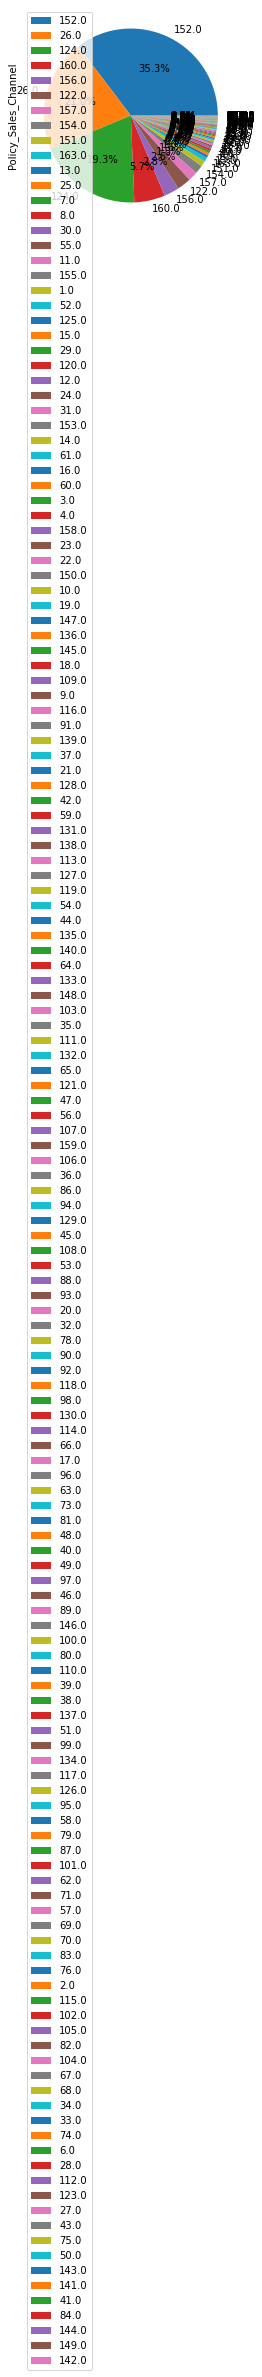

In [361]:
df['Policy_Sales_Channel'].value_counts(normalize=True,dropna=False).plot(kind='pie',legend=True,autopct= '%1.1f%%')


#### Bivariate analysis of Policy_Sales_Channel column

<AxesSubplot:xlabel='Policy_Sales_Channel'>

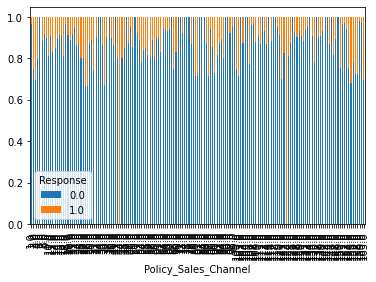

In [362]:
Policy_Sales_Channel = pd.crosstab(df['Policy_Sales_Channel'],df['Response'])
Policy_Sales_Channel.div(Policy_Sales_Channel.sum(1).astype('float'),axis=0).plot(kind='bar', stacked=True)

#### Univariate analysis of Vehicle_Age column

In [363]:
df['Vehicle_Age'].value_counts(dropna=False)

1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: Vehicle_Age, dtype: int64

<AxesSubplot:ylabel='Vehicle_Age'>

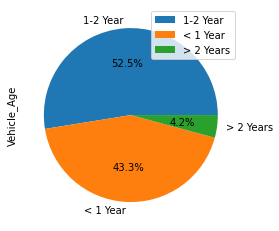

In [364]:
df['Vehicle_Age'].value_counts(normalize=True,dropna=False).plot(kind='pie',legend=True,autopct= '%1.1f%%')


#### Bivariate analysis of Vehicle_Age column

<AxesSubplot:xlabel='Vehicle_Age'>

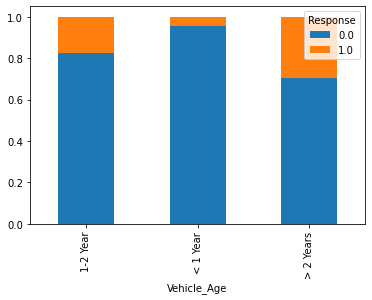

In [365]:
Vehicle_Age = pd.crosstab(df['Vehicle_Age'],df['Response'])
Vehicle_Age.div(Vehicle_Age.sum(1).astype('float'),axis=0).plot(kind='bar', stacked=True)

#### Univariate analysis of Age column

Text(0.5, 1.0, 'Age')

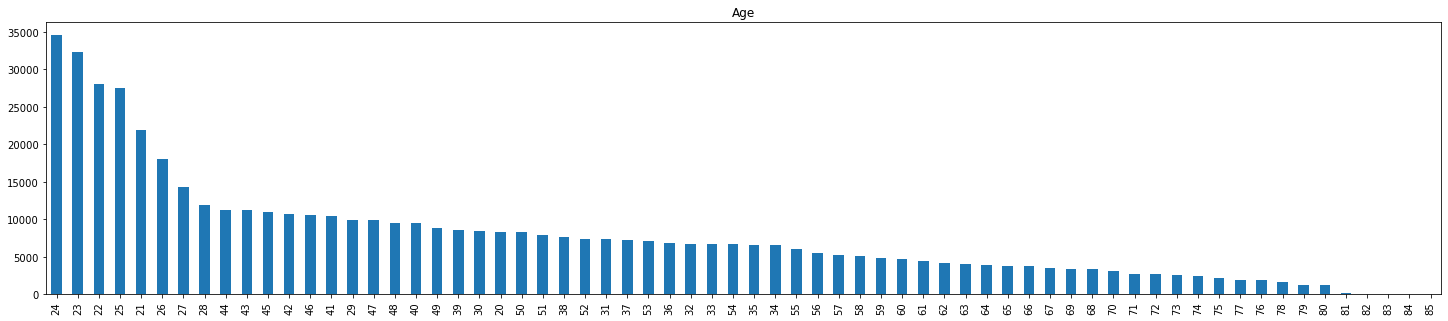

In [366]:
df["Age"].value_counts().plot.bar(figsize=(25,5))
plt.title("Age")

/home/kiran/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age')

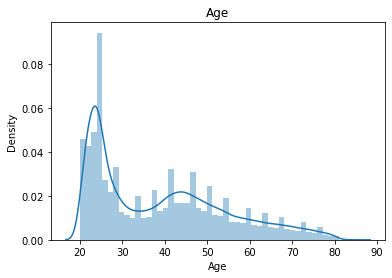

In [367]:
sns.distplot(df['Age'])
df['Age'].plot
plt.title("Age")


#### Bivariate analysis of Age column

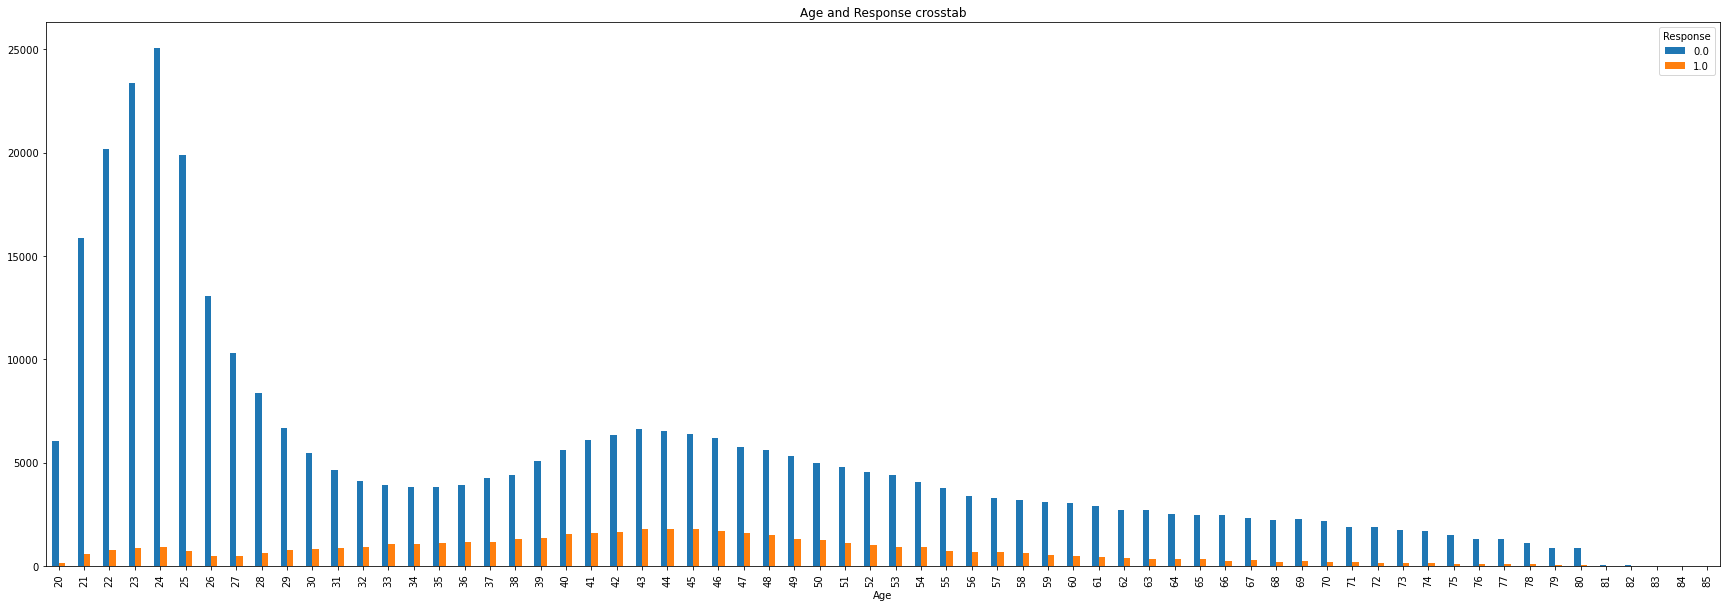

In [368]:
DL = pd.crosstab(df['Age'], df['Response'])
DL.plot(kind="bar", figsize=(30, 10))
plt.title("Age and Response crosstab")
plt.show()

#### Univariate analysis of Vintage column

In [369]:
#converting vitange in days to months and rounding off

In [370]:
df['Vintage'] = df['Vintage']/31
df['Vintage'] = df['Vintage'].astype(int)

In [371]:
df['Vintage'].value_counts(dropna=False)

4    54618
2    54611
6    54424
3    54387
1    54379
7    54342
8    54293
5    53770
0    36771
9    36551
Name: Vintage, dtype: int64

<AxesSubplot:ylabel='Vintage'>

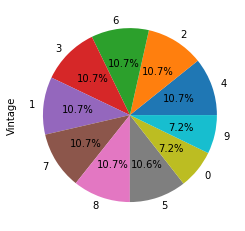

In [372]:
df['Vintage'].value_counts(normalize=True,dropna=False).plot(kind='pie',legend=False,autopct= '%1.1f%%')


#### Bivariate analysis of Vintage column

<AxesSubplot:xlabel='Vintage'>

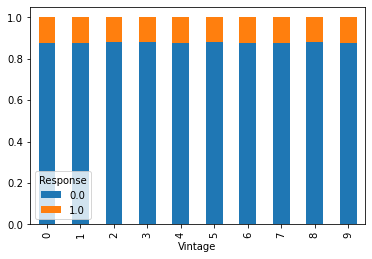

In [373]:
Vintage = pd.crosstab(df['Vintage'],df['Response'])
Vintage.div(Vintage.sum(1).astype('float'),axis=0).plot(kind='bar', stacked=True)

#### Univariate analysis of Annual_Premium column

/home/kiran/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Annual_Premium')

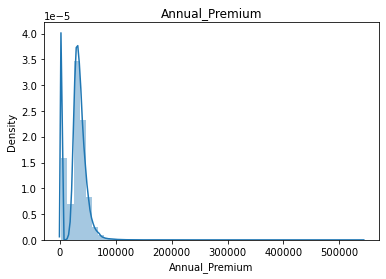

In [374]:
sns.distplot(df['Annual_Premium'])
df['Annual_Premium'].plot
plt.title("Annual_Premium")

## Encoding of categorical variables

In [375]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,7,1.0,train
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,5,0.0,train
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,0,1.0,train
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,6,0.0,train
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,1,0.0,train


In [376]:
df['Gender'] = df['Gender'].map({'Male':0,'Female':1})

In [377]:
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes':1,'No':0})

In [378]:
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

In [379]:
df['Annual_Premium'] = np.log(df['Annual_Premium'])
df['Annual_Premium'] = df['Annual_Premium'].astype("int")

In [380]:
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype("int")
df['Region_Code'] = df['Region_Code'].astype("int")

In [381]:
# tobescaled_df = df[['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']]
# sc = StandardScaler()
# #sc = MinMaxScaler()
# scaled_df = sc.fit_transform(tobescaled_df)
# df[['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']] = scaled_df

In [382]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
0,1,0,44,1,28,0,2,1,10,26,7,1.0,train
1,2,0,76,1,3,0,1,0,10,26,5,0.0,train
2,3,0,47,1,28,0,2,1,10,26,0,1.0,train
3,4,0,21,1,11,1,0,0,10,152,6,0.0,train
4,5,1,29,1,41,1,0,0,10,152,1,0.0,train


## Modelling

In [383]:
df.nunique()

id                      508146
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium               7
Policy_Sales_Channel       157
Vintage                     10
Response                     2
source                       2
dtype: int64

In [384]:
train_df = df[df['source']=='train']
test_df = df[df['source']=='test']
test_df.reset_index(inplace=True, drop=True)
train_df.reset_index(inplace=True, drop=True)

In [385]:
train_df['Response'] = train_df['Response'].astype(np.int64, errors='ignore')

/tmp/ipykernel_96781/2745771578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Response'] = train_df['Response'].astype(np.int64, errors='ignore')


In [386]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    381109 non-null  int64 
 1   Gender                381109 non-null  int64 
 2   Age                   381109 non-null  int64 
 3   Driving_License       381109 non-null  int64 
 4   Region_Code           381109 non-null  int64 
 5   Previously_Insured    381109 non-null  int64 
 6   Vehicle_Age           381109 non-null  int64 
 7   Vehicle_Damage        381109 non-null  int64 
 8   Annual_Premium        381109 non-null  int64 
 9   Policy_Sales_Channel  381109 non-null  int64 
 10  Vintage               381109 non-null  int64 
 11  Response              381109 non-null  int64 
 12  source                381109 non-null  object
dtypes: int64(12), object(1)
memory usage: 37.8+ MB


In [387]:
X = train_df.drop(columns=['id','Response','source'])
y = train_df['Response']

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=20)

In [389]:
def evaluate_models(model,X,y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    print(cm)
    report = classification_report(y, y_pred)
    print(report)
    accuracyscore = accuracy_score(y, y_pred)
    print(accuracyscore)
    ConfusionMatrixDisplay(cm).plot()
    roc_score = roc_auc_score(y, y_pred)
    print(roc_score)
    


[[327588    175]
 [ 45610    113]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    327763
           1       0.39      0.00      0.00     45723

    accuracy                           0.88    373486
   macro avg       0.64      0.50      0.47    373486
weighted avg       0.82      0.88      0.82    373486

0.8774117369861253
0.5009687407558971


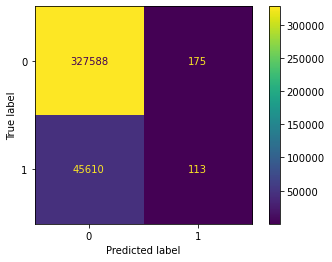

In [390]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train,y_train)
evaluate_models(model,X_train,y_train)

[[6632    4]
 [ 986    1]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      6636
           1       0.20      0.00      0.00       987

    accuracy                           0.87      7623
   macro avg       0.54      0.50      0.47      7623
weighted avg       0.78      0.87      0.81      7623

0.8701298701298701
0.5002051992356328


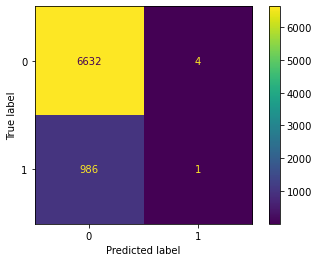

In [391]:
evaluate_models(model,X_test,y_test)

[[325983   1780]
 [ 19624  26099]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97    327763
           1       0.94      0.57      0.71     45723

    accuracy                           0.94    373486
   macro avg       0.94      0.78      0.84    373486
weighted avg       0.94      0.94      0.94    373486

0.9426912923108229
0.7826880308160956


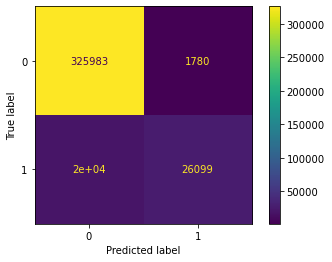

In [392]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
evaluate_models(model,X_train,y_train)

[[6190  446]
 [ 782  205]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6636
           1       0.31      0.21      0.25       987

    accuracy                           0.84      7623
   macro avg       0.60      0.57      0.58      7623
weighted avg       0.81      0.84      0.82      7623

0.8389085661812935
0.5702454695856258


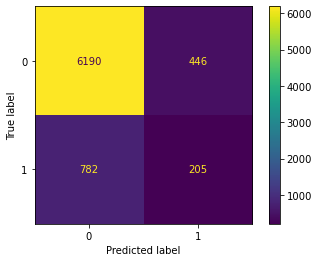

In [393]:
evaluate_models(model,X_test,y_test)

[[324132   3631]
 [ 17780  27943]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    327763
           1       0.89      0.61      0.72     45723

    accuracy                           0.94    373486
   macro avg       0.92      0.80      0.85    373486
weighted avg       0.94      0.94      0.94    373486

0.9426725499750994
0.8000292502536493


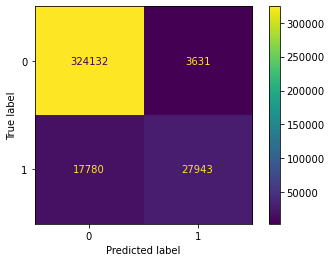

In [394]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
evaluate_models(model,X_train,y_train)

In [404]:
df.columnsns()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
0,1,0,44,1,28,0,2,1,10,26,7,1.0,train
1,2,0,76,1,3,0,1,0,10,26,5,0.0,train
2,3,0,47,1,28,0,2,1,10,26,0,1.0,train
3,4,0,21,1,11,1,0,0,10,152,6,0.0,train
4,5,1,29,1,41,1,0,0,10,152,1,0.0,train


[[6327  309]
 [ 829  158]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6636
           1       0.34      0.16      0.22       987

    accuracy                           0.85      7623
   macro avg       0.61      0.56      0.57      7623
weighted avg       0.81      0.85      0.83      7623

0.8507149416240325
0.5567584291998512


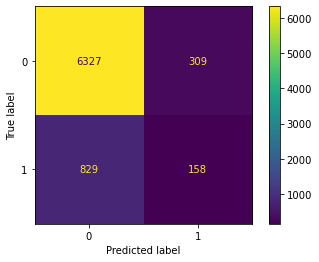

In [395]:
evaluate_models(model,X_test,y_test)

In [406]:
cat_features = ['Gender','Driving_License','Region_Code','Vehicle_Damage','Policy_Sales_Channel']

In [405]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
0,1,0,44,1,28,0,2,1,10,26,7,1.0,train
1,2,0,76,1,3,0,1,0,10,26,5,0.0,train
2,3,0,47,1,28,0,2,1,10,26,0,1.0,train
3,4,0,21,1,11,1,0,0,10,152,6,0.0,train
4,5,1,29,1,41,1,0,0,10,152,1,0.0,train


[[222386 105377]
 [  2975  42748]]
              precision    recall  f1-score   support

           0       0.99      0.68      0.80    327763
           1       0.29      0.93      0.44     45723

    accuracy                           0.71    373486
   macro avg       0.64      0.81      0.62    373486
weighted avg       0.90      0.71      0.76    373486

0.7098900628135995
0.8067153153503235


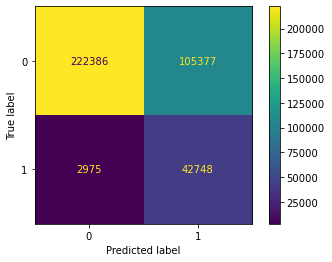

In [414]:
model=LGBMClassifier(boosting_type='gbdt',num_leaves=41,n_estimators=500,max_depth=10,learning_rate=0.04,objective='binary',metric='auc',is_unbalance=True,colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=294,n_jobs=-1)
## Note : Inspired and Used LGBM Classifer from Gowthami's notebook

# lgb.fit(x_train,y_train,categorical_feature=cat_features)
# print(lgb.score(x_train,y_train))
# y_pred_lgb=lgb.predict_proba(x_test)
#model = LGBMClassifier()

model.fit(X_train,y_train)
evaluate_models(model,X_train,y_train)


[[4446 2190]
 [  77  910]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      6636
           1       0.29      0.92      0.45       987

    accuracy                           0.70      7623
   macro avg       0.64      0.80      0.62      7623
weighted avg       0.89      0.70      0.75      7623

0.702610520792339
0.7959838662100983


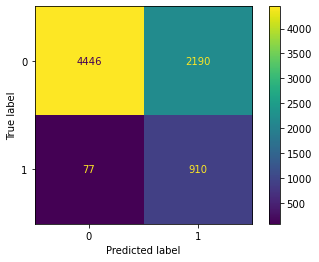

In [408]:
evaluate_models(model,X_test,y_test)

In [409]:
y_pred = model.predict(test_df.drop(columns=['id','source','Response']))

In [410]:
output = pd.DataFrame()
output['id'] = test_df['id']
output['Response'] = pd.Series((y_pred)).astype(int)

In [411]:
output.to_csv("output/Response.csv", index=False)

In [412]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
0,1,0,44,1,28,0,2,1,10,26,7,1,train
1,2,0,76,1,3,0,1,0,10,26,5,0,train
2,3,0,47,1,28,0,2,1,10,26,0,1,train
3,4,0,21,1,11,1,0,0,10,152,6,0,train
4,5,1,29,1,41,1,0,0,10,152,1,0,train
